In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import catboost as cb
import scipy.sparse as sps
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
# read dataset
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")

# Data preprocessing and EDA

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [3]:
# no NaN :)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [3]:
# rename target
rename_dict = {"dep_delayed_15min": "is_delayed"}
train.rename(columns=rename_dict, inplace=True)

In [4]:
# convert date columns to int
for column in ["Month", 'DayofMonth', 'DayOfWeek']:
    train[column] = train[column].str.extract(r'(\d+)')
    test[column] = test[column].str.extract(r'(\d+)')
    train[column] = pd.to_numeric(train[column])
    test[column] = pd.to_numeric(test[column])

In [5]:
# change target class labels to 0/1
train["is_delayed"] = train["is_delayed"].map({"N" : 0, "Y" : 1})

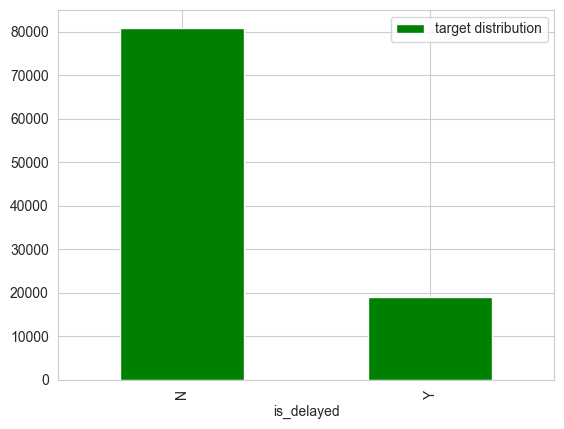

In [5]:
# target class is unbalanced -> StratifiedKFold
train["is_delayed"].value_counts().plot(kind="bar", label="target distribution", color="g");
plt.legend();

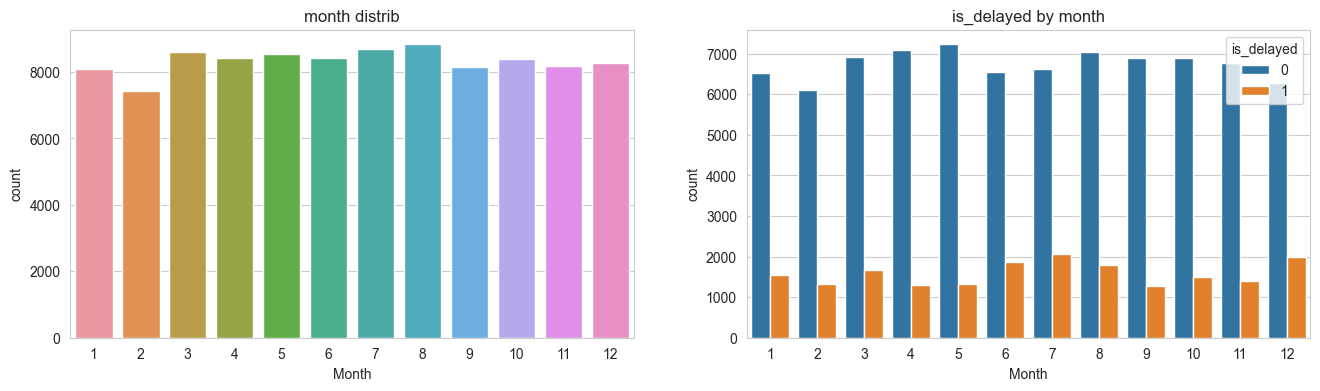

In [35]:
# slightly more delays in summer
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x="Month", ax=ax[0]);
ax[0].set_title("month distrib");
sns.countplot(data=train, x="Month", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by month");

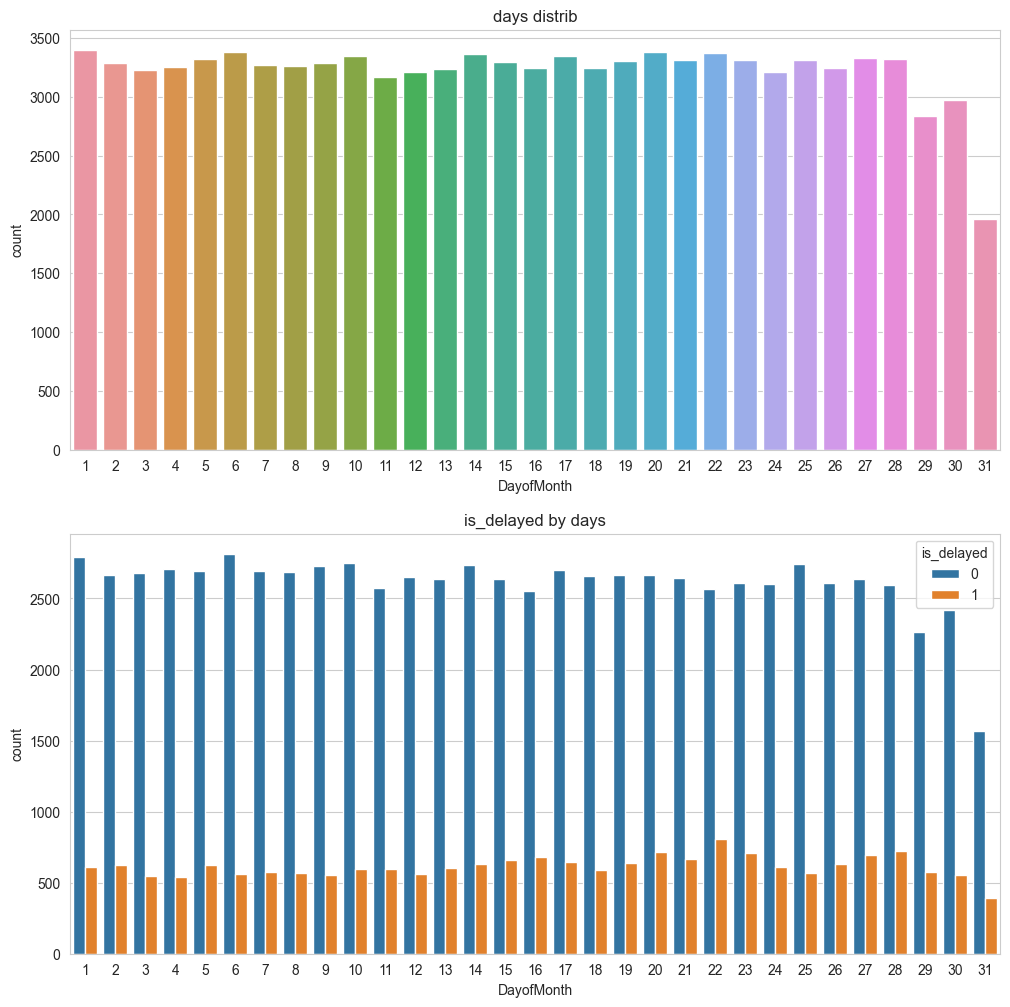

In [36]:
# there only 7 month with 31 day but delay is pretty high
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.countplot(data=train, x="DayofMonth", ax=ax[0]);
ax[0].set_title("days distrib");
sns.countplot(data=train, x="DayofMonth", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by days");

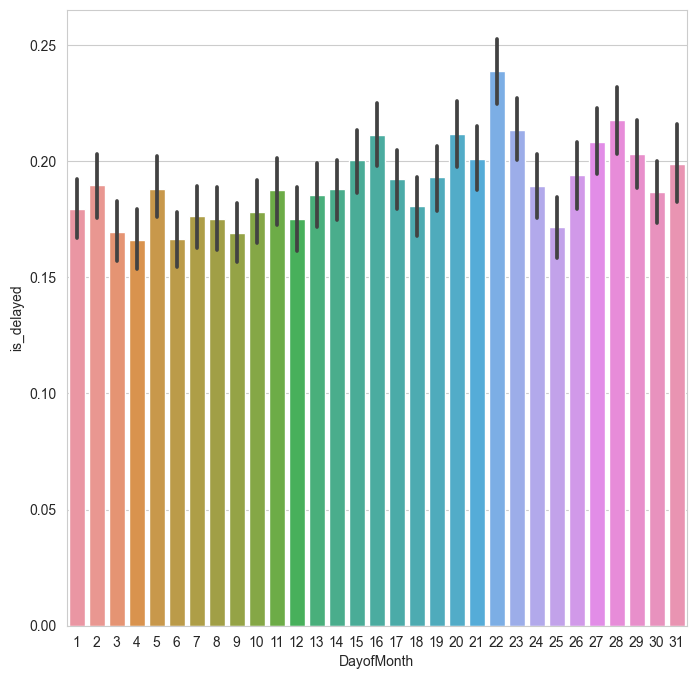

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.barplot(x="DayofMonth", y="is_delayed", data=train, ax=ax);

Text(0.5, 1.0, 'delay rate')

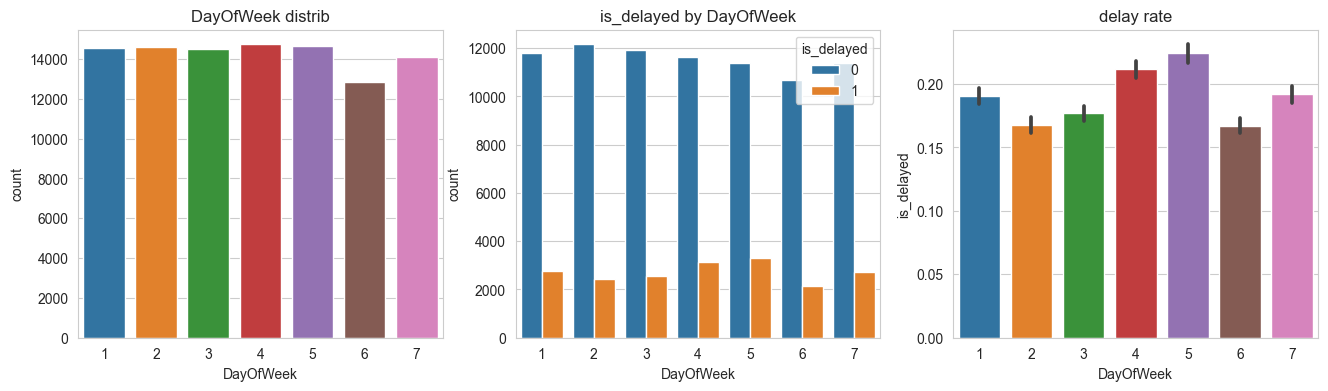

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data=train, x="DayOfWeek", ax=ax[0]);
ax[0].set_title("DayOfWeek distrib");
sns.countplot(data=train, x="DayOfWeek", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by DayOfWeek");
sns.barplot(x="DayOfWeek", y="is_delayed", data=train, ax=ax[2]);
ax[2].set_title("delay rate")

D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


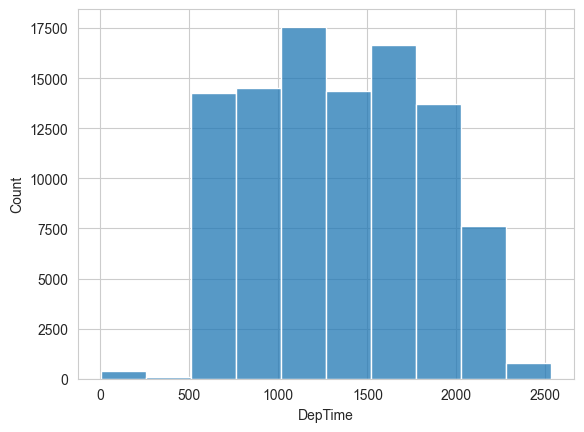

In [20]:
# probably need to parse it to hours, mins etc.
sns.histplot(data=train, x="DepTime", bins=10);

In [9]:
train["DepTime"].describe()

count    100000.000000
mean       1341.523880
std         476.378445
min           1.000000
25%         931.000000
50%        1330.000000
75%        1733.000000
max        2534.000000
Name: DepTime, dtype: float64

Text(0.5, 1.0, 'delay_rate')

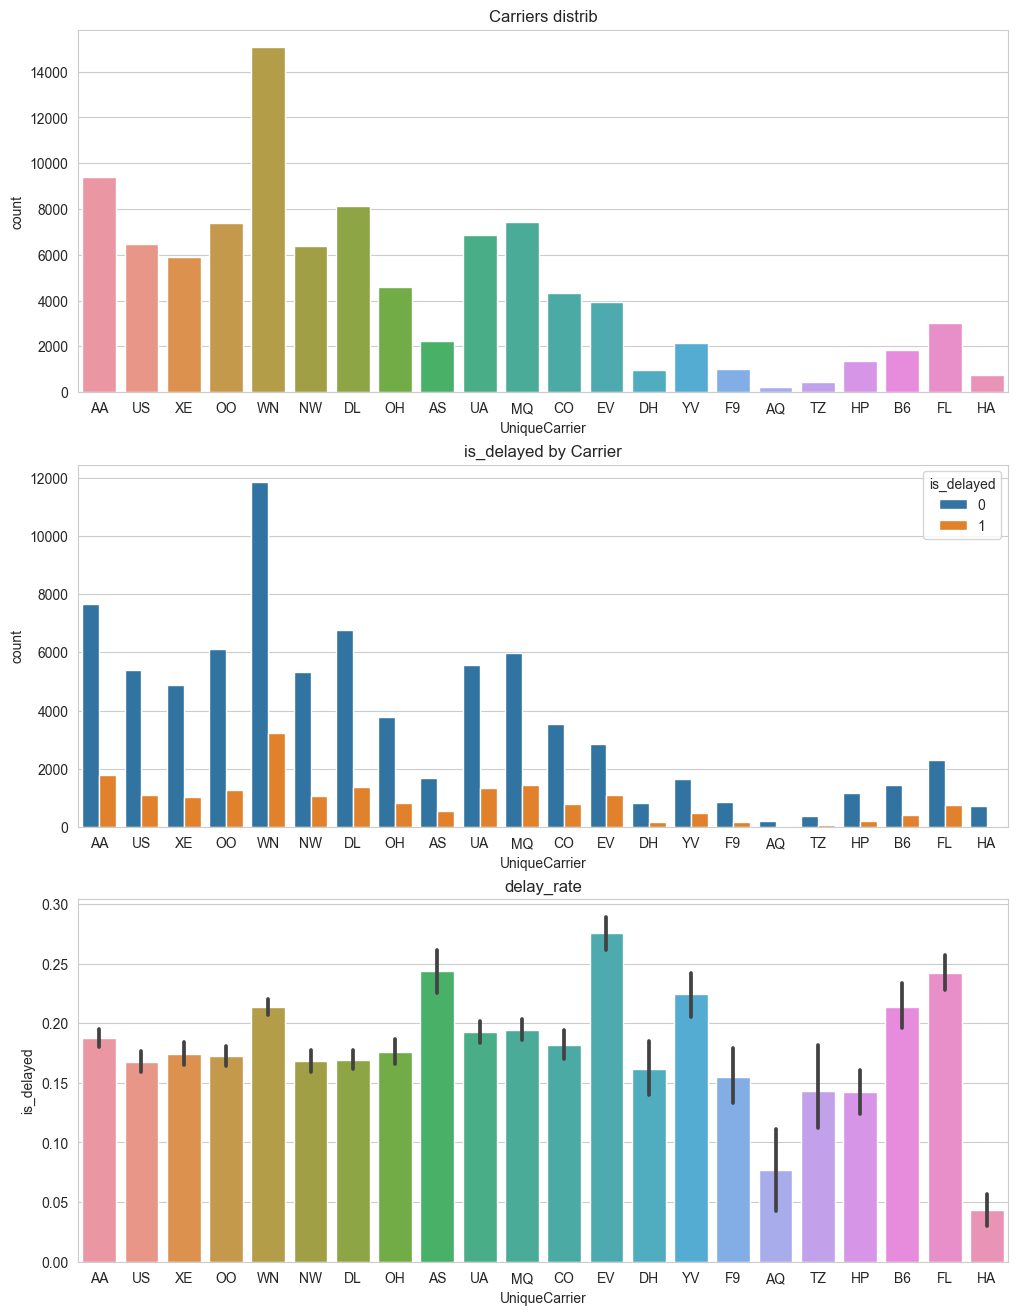

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(12, 16))
sns.countplot(data=train, x="UniqueCarrier", ax=ax[0]);
ax[0].set_title("Carriers distrib");
sns.countplot(data=train, x="UniqueCarrier", hue="is_delayed", ax=ax[1]);
ax[1].set_title("is_delayed by Carrier")
sns.barplot(data=train, x="UniqueCarrier", y="is_delayed", ax=ax[2], orient="v")
ax[2].set_title("delay_rate")

In [6]:
carrier_categories = train["UniqueCarrier"].value_counts().map(lambda x: "small" if x <= 2000 else "medium" if 2000 < x <= 8000 else "big")
carrier_dict = {"big" : [], "medium" : [], "small" : []}
for carrier in carrier_categories.index.values:
    carrier_dict[carrier_categories[carrier]].append(carrier)
carrier_dict

{'big': ['WN', 'AA', 'DL'],
 'medium': ['MQ',
  'OO',
  'UA',
  'US',
  'NW',
  'XE',
  'OH',
  'CO',
  'EV',
  'FL',
  'AS',
  'YV'],
 'small': ['B6', 'HP', 'F9', 'DH', 'HA', 'TZ', 'AQ']}

In [7]:
# too much to plot
unique_origins_num = train["Origin"].unique().shape[0]
unique_dest_num = train["Dest"].unique().shape[0]
print(f"unique origins: {unique_origins_num}")
print(f"unique dest: {unique_dest_num}")

unique origins: 289
unique dest: 289


D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


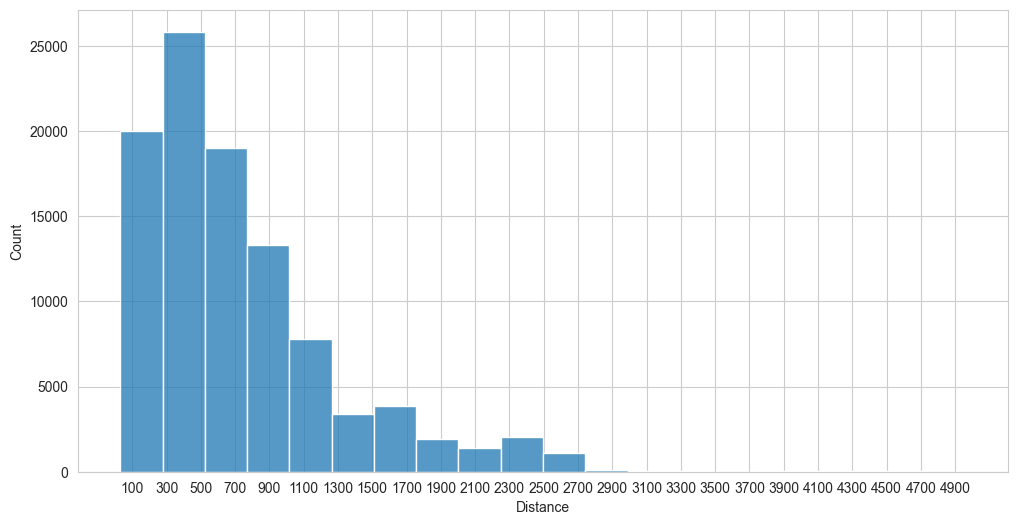

In [19]:
# most flights are short
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(data=train, x="Distance", bins=20);
plt.xticks(np.arange(100, np.max(train["Distance"]), 200));

In [68]:
train["Distance"].describe()

count    100000.00000
mean        729.39716
std         574.61686
min          30.00000
25%         317.00000
50%         575.00000
75%         957.00000
max        4962.00000
Name: Distance, dtype: float64

# Feature engineering

In [7]:
# merge train and test
full_df = pd.concat([train, test], ignore_index=True)
full_df[100000:]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,is_delayed
100000,7,25,3,615,YV,MRY,PHX,598,NaN
100001,4,17,2,739,WN,LAS,HOU,1235,NaN
100002,12,2,7,651,MQ,GSP,ORD,577,NaN
100003,3,25,7,1614,WN,BWI,MHT,377,NaN
100004,6,6,3,1505,UA,ORD,STL,258,NaN
...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,WN,CRP,HOU,187,NaN
199996,11,24,6,1446,UA,ORD,LAS,1515,NaN
199997,1,30,2,1509,OO,ORD,SGF,438,NaN
199998,1,5,5,804,DL,LGA,ATL,761,NaN


In [8]:
# Route = Origin + Dest
full_df["Route"] = full_df["Origin"] + "_" + full_df["Dest"]
# parse time
full_df["DepHour"] = full_df["DepTime"].map(lambda x: (x // 100) % 24)
full_df["DepMinute"] = full_df["DepTime"].map(lambda x: x % 100)
full_df["TimeOfDay"] = full_df["DepHour"].map(lambda x: "morning" if 6 <= x < 12 else
                                                        "afternoon" if 12 <= x < 18 else
                                                        "evening" if 18 <= x <= 23 else
                                                        "night")
# categories for distance
full_df["DistCategory"] = full_df["Distance"].map(lambda x: "short" if x < 500 <= 1000 else
                                                            "medium" if 1000 < x <= 2700 else
                                                            "long")
# carries features
full_df["Carrier_Dest"] = full_df["UniqueCarrier"] + "_" + full_df["Dest"]
full_df["Carrier_Origin"] = full_df["UniqueCarrier"] + "_" + full_df["Origin"]
full_df["Carrier_hour"] = full_df["UniqueCarrier"] + "_" + full_df["DepHour"].astype(str)
full_df["Carrier_size"] = full_df["UniqueCarrier"].map(lambda x: "big" if x in carrier_dict["big"] else
                                                                "small" if x in carrier_dict["small"] else
                                                                "medium")
full_df["Carrier_DistCategory"] = full_df["UniqueCarrier"] + "_" + full_df["DistCategory"]
# weekends
full_df["Weekend"] = full_df["DayOfWeek"].map(lambda x: "Yes" if x in (6, 7) else "No")
# seasons
full_df["Season"] = full_df["Month"].map(lambda x: "winter" if x in (12, 1, 2) else
                                                    "spring" if x in (3, 4, 5) else
                                                    "summer" if x in (6, 7, 8) else
                                                    "autumn")
full_df["Hour_Season"] = full_df["DepHour"].astype(str) + "_" + full_df["Season"]
full_df["Hour_Origin"] = full_df["DepHour"].astype(str) + "_" + full_df["Origin"]
full_df["Season_TimeOfDay"] = full_df["Season"] + "_" + full_df["TimeOfDay"]
full_df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,is_delayed,Route,...,Carrier_Dest,Carrier_Origin,Carrier_hour,Carrier_size,Carrier_DistCategory,Weekend,Season,Hour_Season,Hour_Origin,Season_TimeOfDay
0,8,21,7,1934,AA,ATL,DFW,732,0.0,ATL_DFW,...,AA_DFW,AA_ATL,AA_19,big,AA_long,Yes,summer,19_summer,19_ATL,summer_evening
1,4,20,3,1548,US,PIT,MCO,834,0.0,PIT_MCO,...,US_MCO,US_PIT,US_15,medium,US_long,No,spring,15_spring,15_PIT,spring_afternoon
2,9,2,5,1422,XE,RDU,CLE,416,0.0,RDU_CLE,...,XE_CLE,XE_RDU,XE_14,medium,XE_short,No,autumn,14_autumn,14_RDU,autumn_afternoon
3,11,25,6,1015,OO,DEN,MEM,872,0.0,DEN_MEM,...,OO_MEM,OO_DEN,OO_10,medium,OO_long,Yes,autumn,10_autumn,10_DEN,autumn_morning
4,10,7,6,1828,WN,MDW,OMA,423,1.0,MDW_OMA,...,WN_OMA,WN_MDW,WN_18,big,WN_short,Yes,autumn,18_autumn,18_MDW,autumn_evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,6,5,2,852,WN,CRP,HOU,187,NaN,CRP_HOU,...,WN_HOU,WN_CRP,WN_8,big,WN_short,No,summer,8_summer,8_CRP,summer_morning
199996,11,24,6,1446,UA,ORD,LAS,1515,NaN,ORD_LAS,...,UA_LAS,UA_ORD,UA_14,medium,UA_medium,Yes,autumn,14_autumn,14_ORD,autumn_afternoon
199997,1,30,2,1509,OO,ORD,SGF,438,NaN,ORD_SGF,...,OO_SGF,OO_ORD,OO_15,medium,OO_short,No,winter,15_winter,15_ORD,winter_afternoon
199998,1,5,5,804,DL,LGA,ATL,761,NaN,LGA_ATL,...,DL_ATL,DL_LGA,DL_8,big,DL_long,No,winter,8_winter,8_LGA,winter_morning


In [9]:
train = full_df.iloc[:100000].copy()
test = full_df.iloc[100000:].copy()
test.drop(["is_delayed"], axis=1, inplace=True)

# Feature importance

In [10]:
X_train, y_train = train.drop(["is_delayed"], axis=1), train["is_delayed"]

In [11]:
# categorical and numerical features
cat_features = list(X_train.columns[X_train.dtypes == "object"])
print(f"Cat_features: {cat_features}")
num_features = list(X_train.columns[X_train.dtypes != "object"])
print(f"Num_features: {num_features}")

Cat_features: ['UniqueCarrier', 'Origin', 'Dest', 'Route', 'TimeOfDay', 'DistCategory', 'Carrier_Dest', 'Carrier_Origin', 'Carrier_hour', 'Carrier_size', 'Carrier_DistCategory', 'Weekend', 'Season', 'Hour_Season', 'Hour_Origin', 'Season_TimeOfDay']
Num_features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'DepHour', 'DepMinute', 'LogDistance']


In [12]:
# train and test split
X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, shuffle=True)

In [13]:
# higher weight for delayed
counts = y_train.value_counts()
class_weights = [1, counts[0]/counts[1]]

In [14]:
cat_features_idx = np.where(X_train_part.dtypes == "object")[0]
print(cat_features_idx)

[ 4  5  6  8 11 12 14 15 16 17 18 19 20 21 22 23]


In [15]:
# catboost params
params = dict(
    depth=8,
    l2_leaf_reg=0.5,
    bagging_temperature=2.0,
    border_count=64,
    grow_policy='Lossguide',
    num_leaves=10,
    class_weights=class_weights,
    eval_metric='AUC',
    task_type='GPU',
    loss_function='Logloss')

In [16]:
trn_pool = cb.Pool(X_train_part, y_train_part, cat_features=cat_features_idx)
val_pool = cb.Pool(X_valid_part, y_valid_part, cat_features=cat_features_idx)

model = cb.train(params=params,
                 dtrain=trn_pool,
                 verbose=100,
                 early_stopping_rounds=200,
                 eval_set=val_pool,
                 iterations=3600)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6910741	best: 0.6910741 (0)	total: 78.3ms	remaining: 4m 41s
100:	test: 0.7231524	best: 0.7231524 (100)	total: 1.46s	remaining: 50.7s
200:	test: 0.7295489	best: 0.7295489 (200)	total: 2.88s	remaining: 48.6s
300:	test: 0.7326462	best: 0.7326462 (300)	total: 4.23s	remaining: 46.4s
400:	test: 0.7345170	best: 0.7345170 (399)	total: 5.63s	remaining: 44.9s
500:	test: 0.7361498	best: 0.7361565 (499)	total: 6.99s	remaining: 43.3s
600:	test: 0.7370517	best: 0.7370580 (598)	total: 8.39s	remaining: 41.9s
700:	test: 0.7377462	best: 0.7377462 (700)	total: 9.8s	remaining: 40.5s
800:	test: 0.7386199	best: 0.7386199 (800)	total: 11.2s	remaining: 39.2s
900:	test: 0.7394950	best: 0.7394950 (900)	total: 12.6s	remaining: 37.8s
1000:	test: 0.7399628	best: 0.7399656 (995)	total: 14s	remaining: 36.4s
1100:	test: 0.7406372	best: 0.7406372 (1100)	total: 15.3s	remaining: 34.8s
1200:	test: 0.7411795	best: 0.7411819 (1199)	total: 16.6s	remaining: 33.2s
1300:	test: 0.7417474	best: 0.7417474 (1300)	total:

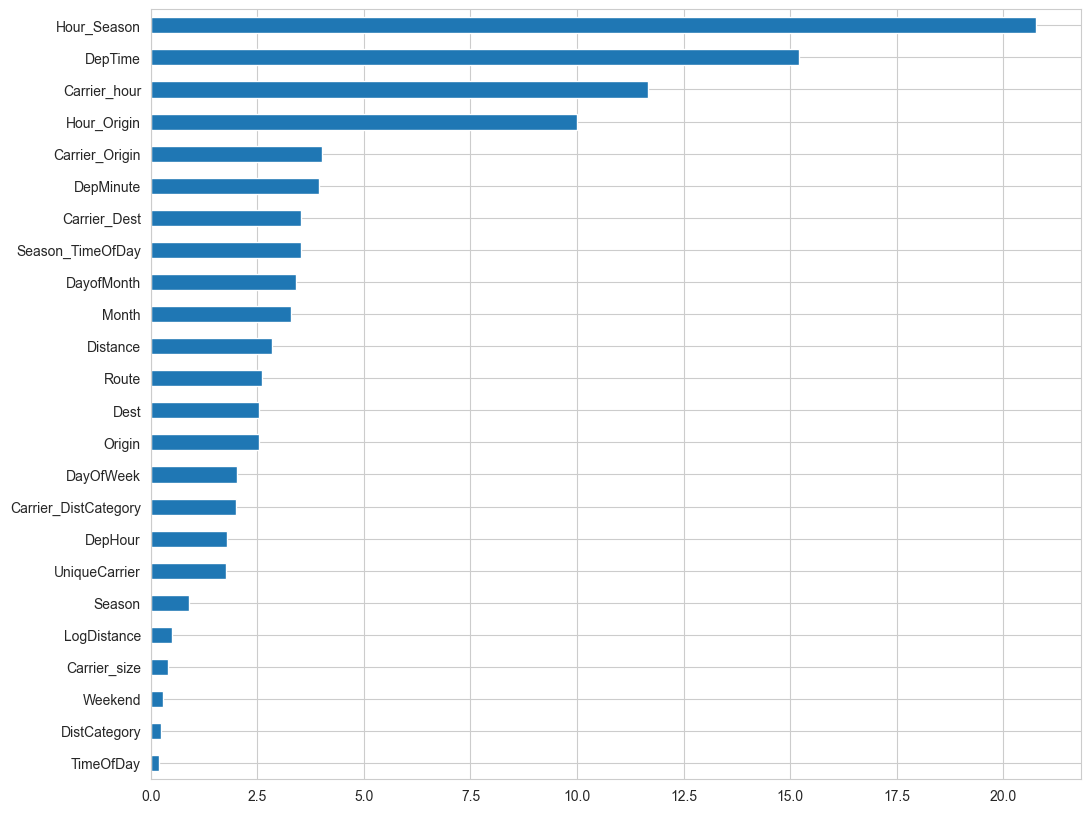

In [17]:
# plot feature importance
def feature_importance(model):
    scores = model.feature_importances_
    indices = [c for c in model.feature_names_]
    ser = pd.Series(dict(zip(indices, scores)))
    ser.sort_values(inplace=True)
    return ser

def plot_feature_importance(model):
    fig, ax = plt.subplots(figsize=(12, 10))
    importance = feature_importance(model)
    importance.plot.barh(ax=ax)

plot_feature_importance(model)

# Modeling

In [18]:
# Pipelines for automatic preprocessing

# Standard scaler for numerical features
std_scaler = StandardScaler()
pipe_num = Pipeline([("scaler", std_scaler)])

# OHE for categorical features
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
pipe_cat = Pipeline([("encoder", one_hot_encoder)])

col_transformer = ColumnTransformer([("num", pipe_num, num_features),
                                     ("cat", pipe_cat, cat_features)])

In [19]:
# X_train after transforming
X_train_transformed = col_transformer.fit_transform(X_train)
X_train_transformed[:5]

array([[ 0.42841367,  0.6022536 ,  1.53049018, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7434282 ,  0.48853824, -0.4779151 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72137414, -1.55833823,  0.52628754, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.30729507,  1.05711504,  1.02838886, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0143346 , -0.98976143,  1.02838886, ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
# let's return the column names
X_train_transformed = pd.DataFrame(X_train_transformed, columns= [col.split("__")[-1] for col in col_transformer.get_feature_names_out()])
X_train_transformed.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,DepHour,DepMinute,LogDistance,UniqueCarrier_AA,UniqueCarrier_AQ,...,Season_TimeOfDay_spring_morning,Season_TimeOfDay_spring_night,Season_TimeOfDay_summer_afternoon,Season_TimeOfDay_summer_evening,Season_TimeOfDay_summer_morning,Season_TimeOfDay_summer_night,Season_TimeOfDay_winter_afternoon,Season_TimeOfDay_winter_evening,Season_TimeOfDay_winter_morning,Season_TimeOfDay_winter_night
0,0.428414,0.602254,1.530490,1.243715,0.004530,1.233486,0.250797,0.372874,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.743428,0.488538,-0.477915,0.433431,0.182040,0.395432,1.042647,0.539538,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.721374,-1.558338,0.526288,0.168934,-0.545405,0.185918,-0.427932,-0.349082,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.307295,1.057115,1.028389,-0.685433,0.248172,-0.652136,-0.823857,0.596462,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.014335,-0.989761,1.028389,1.021202,-0.533223,1.023973,-0.088567,-0.327763,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(X_train_transformed, y_train, test_size=0.3, stratify=y_train, shuffle=True)

In [22]:
# very important !!1!!!!!1!!!!
X_train_part = sps.csr_matrix(X_train_part)
X_valid_part = sps.csr_matrix(X_valid_part)

In [23]:
def score(params):
    print("Params:", params)
    dtrain = xgb.DMatrix(X_train_part, y_train_part)
    dvalid = xgb.DMatrix(X_valid_part, y_valid_part)
    model = xgb.train(params, dtrain, params["num_round"])
    pred = model.predict(dvalid)
    score = roc_auc_score(y_valid_part, pred)
    print(f"Score: {score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize(trials, space, max_evals=10):
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

Param tuning with fixed learning rate

In [26]:
# space for optimization
space = {
    "num_round": 1500,
    "learning_rate": 0.05,
    "max_depth": hp.choice("max_depth", np.arange(1, 14, dtype=int)),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
    "gamma": hp.quniform("gamma", 0.5, 1, 0.01),
    "colsample_bytree": hp.quniform("colsample_bytree", 0.3, 1, 0.05),
    "eval_metric": "auc",
    "objective": "binary:logistic",
}

trials = Trials()
best_params = optimize(trials, space, 150)
best_params

{'colsample_bytree': 0.75,
 'gamma': 0.72,
 'max_depth': 12,
 'min_child_weight': 1.0,
 'subsample': 0.9}

Learning rate tuning

In [28]:
space_lr = {
    "num_round": 1500,
    'colsample_bytree': 0.75,
    'gamma': 0.72,
    'max_depth': 12,
    'min_child_weight': 1.0,
    'subsample': 0.9,
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": hp.quniform("eta", 0.001, 0.05, 0.001),
}

trials = Trials()
best_params = optimize(trials, space_lr, max_evals=80)
best_params

{'eta': 0.037}

In [38]:
# best params after tuning
xgb_best = {
    'colsample_bytree': 0.75,
    'gamma': 0.72,
    'max_depth': 12,
    'min_child_weight': 1.0,
    'subsample': 0.9,
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.037,
}

In [39]:
dtrain = xgb.DMatrix(X_train_part, y_train_part)
dvalid = xgb.DMatrix(X_valid_part, y_valid_part)
watchlist = [(dvalid, "valid"), (dtrain, "train")]
boost = xgb.train(xgb_best, dtrain, 1350, watchlist)

D:\Programms\PyCharm 2022.3.1\saves\edu_project\venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	valid-auc:0.69156	train-auc:0.75458
[1]	valid-auc:0.70854	train-auc:0.77747
[2]	valid-auc:0.71342	train-auc:0.78733
[3]	valid-auc:0.71821	train-auc:0.79131
[4]	valid-auc:0.72045	train-auc:0.79315
[5]	valid-auc:0.72107	train-auc:0.79430
[6]	valid-auc:0.72260	train-auc:0.79576
[7]	valid-auc:0.72288	train-auc:0.79843
[8]	valid-auc:0.72312	train-auc:0.79878
[9]	valid-auc:0.72376	train-auc:0.79836
[10]	valid-auc:0.72437	train-auc:0.80071
[11]	valid-auc:0.72503	train-auc:0.80222
[12]	valid-auc:0.72599	train-auc:0.80251
[13]	valid-auc:0.72663	train-auc:0.80328
[14]	valid-auc:0.72724	train-auc:0.80387
[15]	valid-auc:0.72764	train-auc:0.80523
[16]	valid-auc:0.72770	train-auc:0.80514
[17]	valid-auc:0.72794	train-auc:0.80451
[18]	valid-auc:0.72865	train-auc:0.80591
[19]	valid-auc:0.72951	train-auc:0.80762
[20]	valid-auc:0.72977	train-auc:0.80826
[21]	valid-auc:0.72987	train-auc:0.80987
[22]	valid-auc:0.73013	train-auc:0.81089
[23]	valid-auc:0.73043	train-auc:0.81292
[24]	valid-auc:0.73066	tra

In [60]:
X_train_transformed_sparse = sps.csr_matrix(X_train_transformed)

In [75]:
dtrain = xgb.DMatrix(X_train_transformed_sparse, y_train)
watchlist = [(dtrain, "train")]
boost = xgb.train(xgb_best, dtrain, 1380, evals=watchlist)

[0]	train-auc:0.74944
[1]	train-auc:0.76684
[2]	train-auc:0.77216
[3]	train-auc:0.77535
[4]	train-auc:0.77826
[5]	train-auc:0.78060
[6]	train-auc:0.78203
[7]	train-auc:0.78452
[8]	train-auc:0.78523
[9]	train-auc:0.78522
[10]	train-auc:0.78771
[11]	train-auc:0.78856
[12]	train-auc:0.78849
[13]	train-auc:0.78939
[14]	train-auc:0.78996
[15]	train-auc:0.79213
[16]	train-auc:0.79164
[17]	train-auc:0.79124
[18]	train-auc:0.79341
[19]	train-auc:0.79514
[20]	train-auc:0.79673
[21]	train-auc:0.79839
[22]	train-auc:0.79893
[23]	train-auc:0.79999
[24]	train-auc:0.80134
[25]	train-auc:0.80176
[26]	train-auc:0.80253
[27]	train-auc:0.80246
[28]	train-auc:0.80363
[29]	train-auc:0.80490
[30]	train-auc:0.80524
[31]	train-auc:0.80592
[32]	train-auc:0.80695
[33]	train-auc:0.80784
[34]	train-auc:0.80843
[35]	train-auc:0.80926
[36]	train-auc:0.81040
[37]	train-auc:0.81068
[38]	train-auc:0.81131
[39]	train-auc:0.81189
[40]	train-auc:0.81218
[41]	train-auc:0.81296
[42]	train-auc:0.81374
[43]	train-auc:0.8144

In [76]:
test_transformed = col_transformer.transform(test)
test_transformed = pd.DataFrame(test_transformed, columns= [col.split("__")[-1] for col in col_transformer.get_feature_names_out()])
test_transformed = sps.csr_matrix(test_transformed)
dtest = xgb.DMatrix(test_transformed)

In [77]:
pred = boost.predict(dtest)

In [74]:
pd.Series(pred, name="dep_delayed_15min").to_csv(
    "kaggle_submission_xgb_full_tuned.csv", index_label="id", header=True
)

# Linear model

In [ ]:
space_logit = {
    "penalty" : hp.choice("penalty", ["l1", "l2"]),
    "C" : hp.loguniform("C", -4 * np.log(10), 4 * np.log(10)),
    "solver" : "liblinear"
}

def score_logit(params):
    print("Params: ", params)
    lin_model = LogisticRegression(**params)
    lin_model.fit(X_train_part, y_train_part)
    pred = lin_model.predict_proba(X_valid_part)[:, 1]
    score = roc_auc_score(y_valid_part, pred)
    print(f"Score:{score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize_logit(trials, space, max_evals=10):
    best = fmin(score_logit, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

In [ ]:
trials = Trials()
optimize_logit(trials, space_logit, 1)

In [82]:
best_logit_params = {
    'C': 0.18126298865195695,
    'penalty': "l1",
    'solver' : 'liblinear'
}

let's take the weighted answer of the two models and put it all together into one model

In [80]:
from sklearn.base import BaseEstimator

class My_Model(BaseEstimator):
    def __init__(self, w=None, logit_params=None, xgb_params=None):
        self.logit = None
        self.boost = None
        self.w = w
        self.logit_params = logit_params
        self.xgb_params = xgb_params

    def get_params(self, deep=True):
        return {"w": self.w, "logit_params" : self.logit_params, "xgb_params" : self.xgb_params}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X: np.array, y: np.array):
        train = sps.csr_matrix(X)
        dtrain = xgb.DMatrix(train, y)
        self.boost = xgb.train(self.xgb_params, dtrain, 1380)
        self.logit = LogisticRegression(**self.logit_params).fit(train, y)
        return self

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        boost_pred = self.boost.predict(dtest)
        logit_pred = self.logit.predict_proba(X)[:, 1]
        return self.w * boost_pred + (1 - self.w) * logit_pred

In [83]:
mm = My_Model(0.98, best_logit_params, xgb_best)

In [84]:
mm.fit(X_train_transformed, y_train)

My_Model(logit_params={'C': 0.18126298865195695, 'penalty': 'l1',
                       'solver': 'liblinear'},
         w=0.98,
         xgb_params={'colsample_bytree': 0.75, 'eval_metric': 'auc',
                     'gamma': 0.72, 'learning_rate': 0.035, 'max_depth': 12,
                     'min_child_weight': 1.0, 'objective': 'binary:logistic',
                     'subsample': 0.9})

In [85]:
my_model_test_pred = mm.predict(test_transformed)

In [86]:
# pd.Series(my_model_test_pred, name="dep_delayed_15min").to_csv(
#     "kaggle_submission.csv", index_label="id", header=True
# )